# Taxi Trip Geospatial Cleaning 

In this notebook we look to clean a dataset containing information around individual taxi trips in and around New York City. In particular we are focusing on the pickup and drop off locations of the trips. 

## Whats wrong with the data
Below we can see that pickup and dropoff have very large ranges between their maximum and minimum coordinates. A quick google puts NYC between -73.7 and -74.26 longitude, and between  40.92 and 40.497 latitude which was much smaller than the ranges within the data.

## How do we solve this?
There is no one method to solving a problem like this, in this notebook we will be attempting to filter out bad points spatially. As in drawing a polygon around NYC where points outside the polygon should be removed from the sample. This polygon requiers a certain assumption as to where data is considered valid or not. In a business case this is a decision typically made by a SME (subject matter expert) or a PO (product owner).

Our first step is to get rid of the obviously wrong data. Drawing a box or circle around the city with a certain size and then eliminating any points that reside outside of the polygon. This is crude but efficient, it will prove very effective when coupled with a mroe accurate second method.

An assumption made for this notebook is that a taxi in NYC is far more likely to conduct its pickups within NYC than outisde. Thus a way to accurately identify bad data is to focus on the pickup-locations. We can restrict pickup locations to within ciity limits and restrict dropoff locations to the arbitrary bounding box.

In [2]:
import numpy as np
import matplotlib as plt
import pandas as pd
import pyreadr
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin

#### Using python with .rds (R data file) requires some conversion. In python the object we use is called a dataframe and it comes with the Pandas package.

In [21]:
data = pyreadr.read_r('nyc_taxi_data_clean_medium.rds')
df = data[None]

#### Below we see the evidence of the distorted data. Range between min and max is far too big

In [22]:
df['pickup_longitude'].describe()

count    1.482876e+07
mean    -7.397209e+01
std      5.687341e-01
min     -1.578177e+02
25%     -7.399230e+01
50%     -7.398200e+01
75%     -7.396786e+01
max      1.009878e+02
Name: pickup_longitude, dtype: float64

In [23]:
df['pickup_latitude'].describe()

count    1.482876e+07
mean     4.074886e+01
std      4.866608e-01
min     -7.401636e+01
25%      4.073654e+01
50%      4.075343e+01
75%      4.076788e+01
max      7.401463e+01
Name: pickup_latitude, dtype: float64

In [24]:
df['dropoff_longitude'].describe()

count    1.482876e+07
mean    -7.397145e+01
std      5.783764e-01
min     -1.578177e+02
25%     -7.399161e+01
50%     -7.398048e+01
75%     -7.396500e+01
max      1.009878e+02
Name: dropoff_longitude, dtype: float64

In [25]:
df['dropoff_latitude'].describe()

count    1.482876e+07
mean     4.074936e+01
std      4.896054e-01
min     -7.406991e+01
25%      4.073556e+01
50%      4.075394e+01
75%      4.076857e+01
max      7.403593e+01
Name: dropoff_latitude, dtype: float64

#### We should also confirm what data we have to work with other than the coordinates. Two in particular are useful. 

#### The first is bad_data_flag. This is what we will be updating to identify when a data point is suspected to be invalid. It also allows us to input some reasoning as to why the data is invalid.

#### The second is randID. This can be used to select a subset of this data to operate on, especially useful if the machine you are operating on has low memory capacity.

In [26]:
 df = df[df['randID'] == 15].copy() # Sample the data

In [27]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150493 entries, 129 to 14828754
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   medallion             150493 non-null  object  
 1   hack_license          150493 non-null  object  
 2   vendor_id             150493 non-null  category
 3   rate_code             150493 non-null  category
 4   store_and_fwd_flag    150493 non-null  category
 5   pickup_datetime       150493 non-null  float64 
 6   dropoff_datetime      150493 non-null  float64 
 7   passenger_count       150493 non-null  int32   
 8   trip_time_in_secs     150493 non-null  int32   
 9   trip_distance         150493 non-null  float64 
 10  pickup_longitude      150493 non-null  float64 
 11  pickup_latitude       150493 non-null  float64 
 12  dropoff_longitude     150493 non-null  float64 
 13  dropoff_latitude      150493 non-null  float64 
 14  payment_type          150493 non

#### The structure of the data doesn't change from R to a pyhton dataframe. We can explore through the data as such. 

In [28]:
print(df.shape)
print(df.columns)

(150493, 25)
Index(['medallion', 'hack_license', 'vendor_id', 'rate_code',
       'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'trip_time_in_secs', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'payment_type', 'fare_amount', 'surcharge',
       'mta_tax', 'tips', 'tolls', 'total_amount', 'randID',
       'dropoff_minus_pickup', 'bad_data_flag', 'tips_percent'],
      dtype='object')


In [29]:
df.head(1000)

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,fare_amount,surcharge,mta_tax,tips,tolls,total_amount,randID,dropoff_minus_pickup,bad_data_flag,tips_percent
129,F0F0CFE0F353AAB5F87B98BC37C5540D,037BB8A7D2501F9CDCCC70F271A356D6,CMT,1,N,15800.216574,15800.223252,1,577,3.40,...,12.5,0.5,0.5,2.00,0.00,15.50,15,0.006678,,16.000000
167,5C96FE79A28D617F9933C387A65A3061,BDDFA029563EC82E16C335A5B3B1C57F,VTS,1,,15807.981944,15807.989583,1,660,1.83,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.007639,,21.052632
377,85720A3C71973D86C8CA39B0B79B6968,DEF7DC1592397F0C2564B0ABFA2A7CF4,VTS,1,,15807.835417,15807.845139,1,840,5.02,...,16.5,0.5,0.5,4.25,0.00,21.75,15,0.009722,,25.757576
416,62099C3783738399C97EE0D4E35A3F0A,D2923683CFECDB4AECB0D995716F35FF,VTS,1,,15807.878472,15807.888889,1,900,2.84,...,12.5,0.5,0.5,0.00,0.00,13.50,15,0.010417,,0.000000
481,CAC816D410FB0B7B8F3B4B1F39680F97,A9F126F43FAFF4097D227EA49EBCAEEF,VTS,1,,15807.923611,15807.930556,6,600,2.26,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.006944,,21.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100112,58A9ED83D9C9C7481B87ED554AEC24C4,084BEA6D22BB8589234B589E01D00BF1,VTS,1,,15808.347917,15808.349306,1,120,0.23,...,3.5,0.0,0.5,0.00,0.00,4.00,15,0.001389,,0.000000
100114,4D684EE610EA8F13B829260E9DC05BC3,29E6429B40EFDDDC73D6270A431A05D5,VTS,1,,15808.344444,15808.352083,6,660,3.62,...,12.5,0.0,0.5,0.00,0.00,13.00,15,0.007639,,0.000000
100271,DC94C90BDE77EE687F8BB379A349C674,308999419601C5CFE0CA0298879F77E9,VTS,2,,15808.040972,15808.065972,1,2160,20.68,...,52.0,0.0,0.5,0.00,5.33,57.83,15,0.025000,,0.000000
100299,D623C90327F3253FEF1B5F628C2C054B,1DAF7D57E8443EA81E03A73E0ACE3976,VTS,1,,15808.149306,15808.155556,1,540,2.31,...,9.5,0.5,0.5,2.00,0.00,12.50,15,0.006250,,21.052632


#### In this example we are going to limit the NYC taxi services to NYC boundaries. This may turn out to be too restrictive as there are many close destinations outside NYC limits e.g. Newark airport. This example should still work with a different shape file that is larger, for example the state of NY.

#### We can load in a 'shapefile' which contains boundry points along the edges of NYC districts as well as metadata around those districts. The boundaries form polygons which make it easier for us to test with.

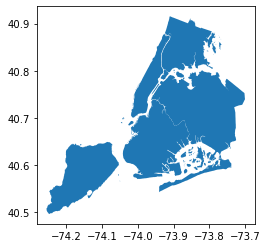

In [30]:
shape=gpd.read_file('BoroughBoundaries/geo_export_38393e35-ee4f-452c-926a-fd0fd2836963.shp')
shape.plot()

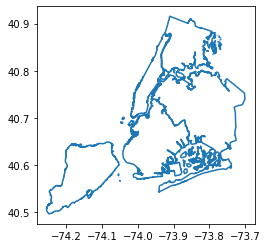

In [31]:
shape.boundary.plot()

In [32]:
type(shape) 

geopandas.geodataframe.GeoDataFrame

In [33]:
shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### The shape file when loaded in with GeoPandas is basically just a dataframe with each polygon as an entry. The polygons themselves are their own object type which strings together a list of coordinates.

In [34]:
shape.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,2.0,Bronx,1.186612e+09,462958.187537,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1,5.0,Staten Island,1.623757e+09,325956.009000,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,1.0,Manhattan,6.366027e+08,361212.476363,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3.0,Brooklyn,1.937593e+09,738745.842046,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
4,4.0,Queens,3.045878e+09,904191.432610,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."


#### A bounding box is a crude  but efficient way of handling the data. We will use it here to speed up our computation as it can get rid of the mostly obvious examples. From there we can use a more advanced method on more ambiguous answers. The bounding box will also serve to  bound the drop-offs, it seems a logical assumption that NYC taxis are more likely to pick up inside the city bounds and leave, than pickup outside the city bounds and come in. This logic could be extended to limiting pickups inside NYC and drop offs inside NY state.

#### The box here is just the min/max latitude and longitude of NYC, this could be easily extended to what you see fit.

In [35]:
bounds_df = shape.bounds
bounding_box = [max(bounds_df['maxx']), max(bounds_df['maxy']), min(bounds_df['minx']), min(bounds_df['miny'])]
maxlong, maxlat, minlong, minlat = max(bounds_df['maxx']), max(bounds_df['maxy']), min(bounds_df['minx']), min(bounds_df['miny'])
maxlong, minlong, maxlat,  minlat

(-73.7000090638712, -74.25559136315213, 40.91553277600008, 40.49611539518921)

In [36]:
bounds_df

,minx,miny,maxx,maxy
0,-73.933606,40.785357,-73.765332,40.915533
1,-74.255591,40.496115,-74.049236,40.648926
2,-74.047730,40.682917,-73.906651,40.879038
3,-74.041897,40.569530,-73.833559,40.739128
4,-73.962620,40.541834,-73.700009,40.801011


Flag all the data outside the bounding box with a identifying tag

In [37]:
df['bad_data_flag'] = np.where(df['pickup_latitude'] > maxlat, df['bad_data_flag'] + 'latitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['pickup_latitude'] < minlat, df['bad_data_flag'] + 'latitude below min ', df['bad_data_flag'])

In [38]:
df['bad_data_flag'] = np.where(df['pickup_longitude'] > maxlong, df['bad_data_flag'] + 'longitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['pickup_longitude'] < minlong, df['bad_data_flag'] + 'longitude below min ', df['bad_data_flag'])

In [39]:
df['bad_data_flag'] = np.where(df['dropoff_latitude'] > maxlat, df['bad_data_flag'] + 'latitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['dropoff_latitude'] < minlat, df['bad_data_flag'] + 'latitude below min ', df['bad_data_flag'])

In [40]:
df['bad_data_flag'] = np.where(df['dropoff_longitude'] > maxlong, df['bad_data_flag'] + 'longitude above max ', df['bad_data_flag'])
df['bad_data_flag'] = np.where(df['dropoff_longitude'] < minlong, df['bad_data_flag'] + 'longitude below min ', df['bad_data_flag'])

In [41]:
df[df['bad_data_flag'] != ''].shape

(113, 25)

#### Bounding box got rid 11438 taxi trips which had any of their trip details start/end outside of the bounding box. 

#### We'll now operate on the leftover data.

In [42]:
df_after_bound = df[df['bad_data_flag'] == '']

#### Get a list of the pickup points of every trip in a shapely.Point format so we can do polygonal comparison with the shapefile. Here we only use pickups because we are assuming that NYC taxis only pickup customers within the city limits.

In [43]:
geometry = [Point(xy) for xy in zip(df_after_bound['pickup_longitude'], df_after_bound['pickup_latitude'])]

In [44]:
type(geometry[0])

shapely.geometry.point.Point

#### Turn the original data into a geodataframe with the previously calculated pickup points as the geometry for each trip. What we also do here is label each taxi trip with the name of the precinct in New York that the trip started. Trips that don't start inside the city will have a 'nan' in that place.

In [45]:
pickups = gpd.GeoDataFrame(df_after_bound, crs=shape.crs , geometry=geometry) #restict df_after_bound to relevant columns to save compute

In [46]:
type(pickups)

geopandas.geodataframe.GeoDataFrame

In [47]:
pointInPolys = sjoin(pickups, shape, how='left',op="within")

In [48]:
out_points = pointInPolys['geometry'][pointInPolys['boro_name'].isnull()]

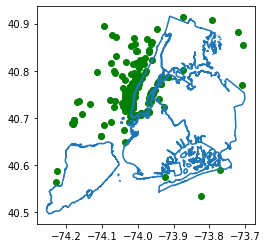

In [53]:
fig, ax = plt.pyplot.subplots()
shape.boundary.plot(ax=ax)
out_points.head(1000).plot(ax=ax, color = 'green')
plt.pyplot.show()

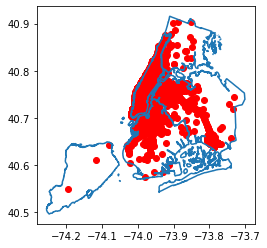

In [54]:
fig, ax = plt.pyplot.subplots()
shape.boundary.plot(ax=ax)
gpd.GeoDataFrame(pointInPolys['geometry'][pointInPolys['boro_name'].notnull()].head(100000)).plot(ax = ax, color = 'red')
plt.pyplot.show()

Depending on the bounding box this method may be very accurate and could exactly meet a clients requirements and definitions. It would be possible for the client to even create their own particular boundary map to work with. However it costs a lot in compute due to the size of the data. This could be improved but

In [60]:
pointInPolys[pointInPolys['boro_name'].notnull()].shape

(150106, 31)

In [61]:
df.shape

(150493, 25)